<a href="https://colab.research.google.com/github/JennyFrost/LLMs/blob/main/Meanings_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 67 kB 3.1 MB/s 
     |████████████████████████████████| 3.3 MB 34.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
import re
import torch
from transformers import AutoTokenizer, AutoModel

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModel.from_pretrained("bert-base-cased", output_hidden_states=True)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def get_word_idx(sent, word='treat'):
     spl = sent.split()
     idx = [spl.index(item) for item in spl if bool(re.match('treat', item, re.IGNORECASE))][0]
     return idx

def get_hidden_states(encoded, token_ids_word, model):
     with torch.no_grad():
         output = model(**encoded)
     last_hidden_states = output[0].squeeze()
     word_tokens_output = last_hidden_states[token_ids_word]
     return word_tokens_output.mean(dim=0)

def get_word_vector(sent, idx, tokenizer, model):
     encoded = tokenizer.encode_plus(sent, return_tensors="pt")
     token_ids_word = np.where(np.array(encoded.word_ids()) == idx)
     return get_hidden_states(encoded, token_ids_word, model)

Возьмем выборку из 51 предложения со словом 'treat', встречающемся в трех различных значениях: "обращаться" (с кем-либо как-либо), "лечить", "угощать/баловать". Извлечем скрытые состояния с последнего (12-го) слоя трансформера для слова 'treat' из каждого предложения (усредняя по сабтокенам, если их больше одного для данного слова). Далее с помощью алгоритма K-Means разделим все точки (51 шт.) на 3 кластера и проверим, преобладает ли в каждом кластере одно определенное значение из трёх.

In [ ]:
sentences = [
             'And you deserve to have someone treat you like a queen.',
             '"To think I should have come all the way from New York to treat him, with the cure right here," he observed to her, smilingly.',
             'In some cases the Croatian authorities inexplicably treat members of the same family differently.',
             '"You treat a man as coward because he has a tactical sense.',
             'And we can treat that.',
             """"Well," returns the old man, "it's true that I don't see company, Mr. George, and that I don't treat.""",
             'I treat this woman and she exits.',
             'Englishmen do not know how to treat women.',
             'We will spend thy money there or at the theatre, or we will treat her to French wine or Cognac in the Aurelius Garden, but the tickets we will not buy.',
             "We haven't got enough beds; why should we treat foreigners?",
             'And you understand I have to treat this as a session.',
             "So let's treat her like any other mother.",
             'He hoped that the members would treat it accordingly.',
             'All this was done on the inspiration of the moment: a second before he had no idea that he would go and treat the peasant woman.',
             "They treat us like we're lunch ladies.",
             'I need to treat George.',
             'He requests you will not be offended, if he seems to take little notice of you in company, and only to treat you as a child.',
             'However, if you can be reasonable, and receive and treat me as a friend, I will come as I used to.',
             "I'm having a hard time understanding why I would open her up when I could treat it endoscopically.",
             "Let's go, Koreiko, my treat, I'm treating everyone!",
             'Well, then, treat me to some Lafitte with lemonade.',
             'And she treated him to fine food and he smelt of oils and perfumes for months afterwards.',
             "Well, I thought I'd treat myself and wash the breakfast dishes first.",
             'At what point did you decide it was okay to treat people like this?',
             "I'm a doctor myself, and I treat myself on my own.",
             "Our people we'll treat at Arkadia.",
             'I know you may treat this statement as compromised.',
             "My father didn't treat it as a story.",
             "I've recommended we treat this as a hostile incursion.",
             "I'm sick of the way you treat your wife, that's what!",
             "You said to treat this like the real thing, right?",
             'Probably carjacked the doctor, forced him to treat her, and then she killed him.',
             'He was willing to pay them handsomely, to keep them busy, to treat them with almost princely courtesy, but he must have the utmost loyalty.',
             "I don't care how we treat the dean tonight.",
             'What shall I treat you with, young people?',
             "Gentlemen students ... you ought to treat a little old man.",
             "I'm gonna go ahead and treat myself.",
             "I'm fed up with living here, the way you treat me...",
             "If you want me to treat you, leave a deposit.",
             'I was called here to treat this lady.',
             'We lost track of you the other night before I had a chance to treat your brain hemorrhage.',
             'Treat this like a regular case.',
             'Your Honor, permission to treat the witness as hostile.',
             'Robert Zane to treat me like a partner, and then you turned around, and you cut my legs out.',
             "He didn't want Meggie to grow up, he wanted the little girl he could treat as his treasured babe.",
             "You are free to treat this like a joke, Mr. Nighthorse, but you have 24 hours to respond to my client's complaint.",
             "I will do what you wish and ask no questions; I will obey you with my life; treat me as a son, and you will find I have a son's devotion.",
             'You taught me exactly how I should treat you.',
             'Later, maybe, I will treat you to champagne even. It will all depend on you.',
             'He could treat himself to nicer digs.',
             'While they treated us as a cross between naughty children and criminals up for sentencing.',
  ]

In [ ]:
sentences1 = [
             'And you deserve to have someone treat you like a queen.',
             '"To think I should have come all the way from New York to treat him, with the cure right here," he observed to her, smilingly.',
             'In some cases the Croatian authorities inexplicably treat members of the same family differently.',
             '"You treat a man as coward because he has a tactical sense.',
             'And we can treat that.',
             """"Well," returns the old man, "it's true that I don't see company, Mr. George, and that I don't treat.""",
             'I treat this woman and she exits.',
             'Englishmen do not know how to treat women.',
             'We will spend thy money there or at the theatre, or we will treat her to French wine or Cognac in the Aurelius Garden, but the tickets we will not buy.',
             "We haven't got enough beds; why should we treat foreigners?",
             'And you understand I have to treat this as a session.',
             "So let's treat her like any other mother.",
             'He hoped that the members would treat it accordingly.',
             'All this was done on the inspiration of the moment: a second before he had no idea that he would go and treat the peasant woman.',
             "They treat us like we're lunch ladies.",
             'I need to treat George.',
             'He requests you will not be offended, if he seems to take little notice of you in company, and only to treat you as a child.',
             'However, if you can be reasonable, and receive and treat me as a friend, I will come as I used to.',
             "I'm having a hard time understanding why I would open her up when I could treat it endoscopically.",
             "Let's go, Koreiko, my treat, I'm treating everyone!",
             'Well, then, treat me to some Lafitte with lemonade.',
             'And she treated him to fine food and he smelt of oils and perfumes for months afterwards.',
             "Well, I thought I'd treat myself and wash the breakfast dishes first.",
             'At what point did you decide it was okay to treat people like this?',
             "I'm a doctor myself, and I treat myself on my own.",
             "Our people we'll treat at Arkadia.",
             'I know you may treat this statement as compromised.',
             "My father didn't treat it as a story.",
             "I've recommended we treat this as a hostile incursion.",
             'Probably carjacked the doctor, forced him to treat her, and then she killed him.',
             "I don't care how we treat the dean tonight.",
             'What shall I treat you with, young people?',
             "Gentlemen students ... you ought to treat a little old man.",
             "I'm gonna go ahead and treat myself.",
             "If you want me to treat you, leave a deposit.",
             'I was called here to treat this lady.',
             'We lost track of you the other night before I had a chance to treat your brain hemorrhage.',
             'Later, maybe, I will treat you to champagne even. It will all depend on you.',
             'He could treat himself to nicer digs.'
  ]

In [ ]:
random.shuffle(sentences1)
sentences1

['If you want me to treat you, leave a deposit.',
 '"Well," returns the old man, "it\'s true that I don\'t see company, Mr. George, and that I don\'t treat.',
 'In some cases the Croatian authorities inexplicably treat members of the same family differently.',
 "Our people we'll treat at Arkadia.",
 'What shall I treat you with, young people?',
 'Gentlemen students ... you ought to treat a little old man.',
 "Well, I thought I'd treat myself and wash the breakfast dishes first.",
 "I'm gonna go ahead and treat myself.",
 'And we can treat that.',
 'He requests you will not be offended, if he seems to take little notice of you in company, and only to treat you as a child.',
 'Well, then, treat me to some Lafitte with lemonade.',
 'All this was done on the inspiration of the moment: a second before he had no idea that he would go and treat the peasant woman.',
 'And you understand I have to treat this as a session.',
 "So let's treat her like any other mother.",
 'He hoped that the membe

In [ ]:
embeddings = []

for sent in sentences1:
  word_idx = get_word_idx(sent)
  word_embedding = get_word_vector(sent, word_idx, tokenizer, model)
  embeddings.append(word_embedding.numpy())

In [ ]:
X = np.array(embeddings)
X.shape

(39, 768)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=142).fit(X)

In [ ]:
kmeans.cluster_centers_

array([[ 0.24547376, -0.08751936,  0.12477576, ...,  0.19388887,
        -0.7036678 ,  0.4829322 ],
       [ 0.17091516,  0.04065641,  0.08496862, ...,  0.22686855,
         0.07004869, -0.09520662],
       [ 0.36464438,  0.51723385,  0.64648795, ..., -0.00351766,
         0.24629536, -0.3740961 ]], dtype=float32)

In [ ]:
kmeans.labels_

array([0, 1, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0], dtype=int32)

In [ ]:
for cluster in [0, 1, 2]:
  print('Кластер {}:'.format(cluster+1), end='\n')
  for label, sent in zip(kmeans.labels_, sentences):
    if label == cluster:
      print(label, '\t', sent)

Кластер 1:
0 	 And you deserve to have someone treat you like a queen.
0 	 In some cases the Croatian authorities inexplicably treat members of the same family differently.
0 	 And we can treat that.
0 	 We will spend thy money there or at the theatre, or we will treat her to French wine or Cognac in the Aurelius Garden, but the tickets we will not buy.
0 	 He hoped that the members would treat it accordingly.
0 	 They treat us like we're lunch ladies.
0 	 I need to treat George.
0 	 However, if you can be reasonable, and receive and treat me as a friend, I will come as I used to.
0 	 I'm having a hard time understanding why I would open her up when I could treat it endoscopically.
0 	 Let's go, Koreiko, my treat, I'm treating everyone!
0 	 At what point did you decide it was okay to treat people like this?
0 	 I'm sick of the way you treat your wife, that's what!
0 	 You said to treat this like the real thing, right?
0 	 I don't care how we treat the dean tonight.
0 	 What shall I tre

In [ ]:
meanings = np.array([[3, 11, 12],
          [1, 4, 7],
          [3, 6, 3]]).T

In [ ]:
normed_matrix = normalize(meanings, axis=1, norm='l1')
normed_matrix

array([[0.42857143, 0.14285714, 0.42857143],
       [0.52380952, 0.19047619, 0.28571429],
       [0.54545455, 0.31818182, 0.13636364]])

In [ ]:
df = pd.DataFrame(normed_matrix)
df.columns = ['обращаться', 'лечить', 'угощать']
df

,обращаться,лечить,угощать
0,0.428571,0.142857,0.428571
1,0.523810,0.190476,0.285714
2,0.545455,0.318182,0.136364


В таблице по строчкам представлены доли каждого из значений глагола 'treat' в каждом кластере. Из этих данных нельзя сказать, что в одном кластере преобладает одно значение, в другом - другое, а в третьем - третье. Например, значение "обращаться" преобладает во всех трех кластерах. Таким образом, в данном случае точки не группируются по значениям слова, либо качество кластеризации не позволяет этого увидеть.

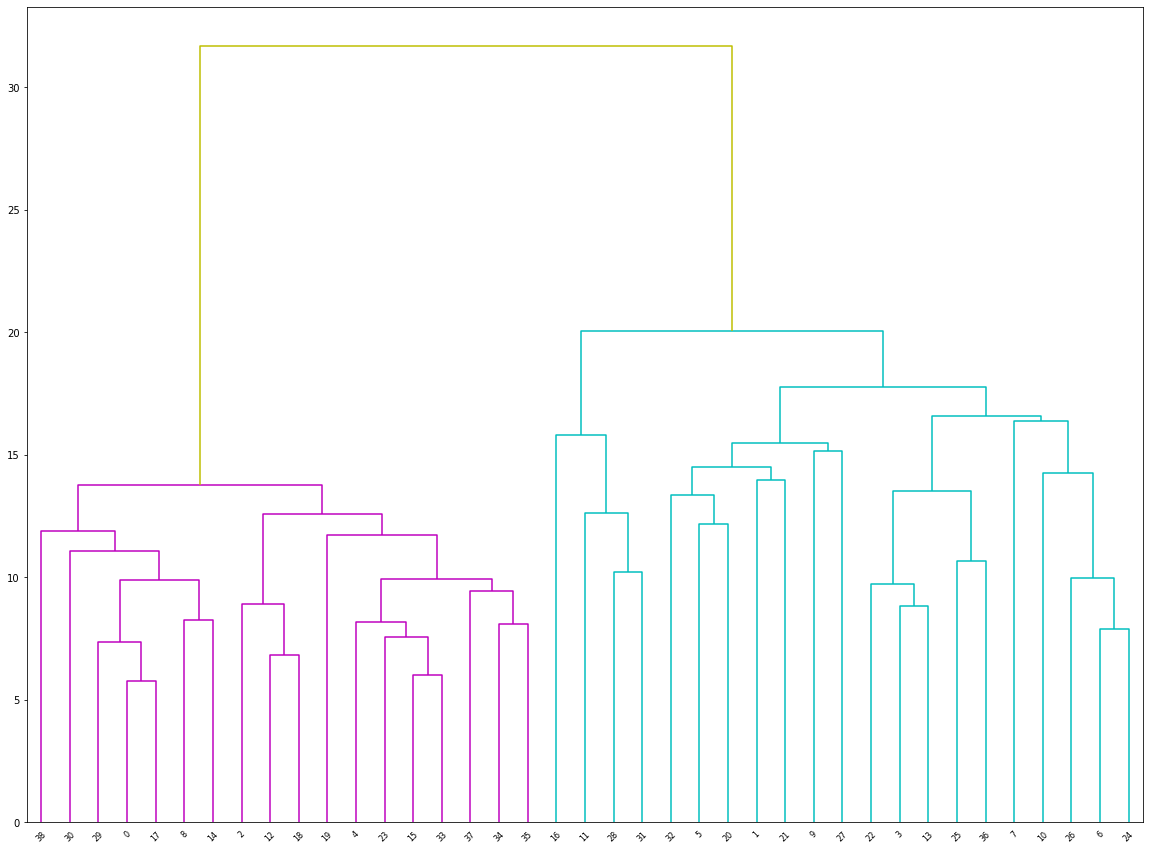

In [ ]:
hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
linked = hierarchy.linkage(X, 'ward', 'euclidean')

labelList = range(1, 52)

plt.figure(figsize=(20, 15))
hierarchy.dendrogram(linked, above_threshold_color='y')
plt.show()

In [ ]:
# кластеризация с расстоянием Варда
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)


array([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1])

In [ ]:
for clust in [0, 1]:
  print('Cluster ', clust)
  for label, sent in zip(cluster.fit_predict(X), sentences1):
    if label == clust:
      print(label, '\t', sent)

Cluster  0
0 	 "Well," returns the old man, "it's true that I don't see company, Mr. George, and that I don't treat.
0 	 Our people we'll treat at Arkadia.
0 	 Gentlemen students ... you ought to treat a little old man.
0 	 Well, I thought I'd treat myself and wash the breakfast dishes first.
0 	 I'm gonna go ahead and treat myself.
0 	 He requests you will not be offended, if he seems to take little notice of you in company, and only to treat you as a child.
0 	 Well, then, treat me to some Lafitte with lemonade.
0 	 All this was done on the inspiration of the moment: a second before he had no idea that he would go and treat the peasant woman.
0 	 So let's treat her like any other mother.
0 	 We will spend thy money there or at the theatre, or we will treat her to French wine or Cognac in the Aurelius Garden, but the tickets we will not buy.
0 	 I've recommended we treat this as a hostile incursion.
0 	 We haven't got enough beds; why should we treat foreigners?
0 	 My father didn't t

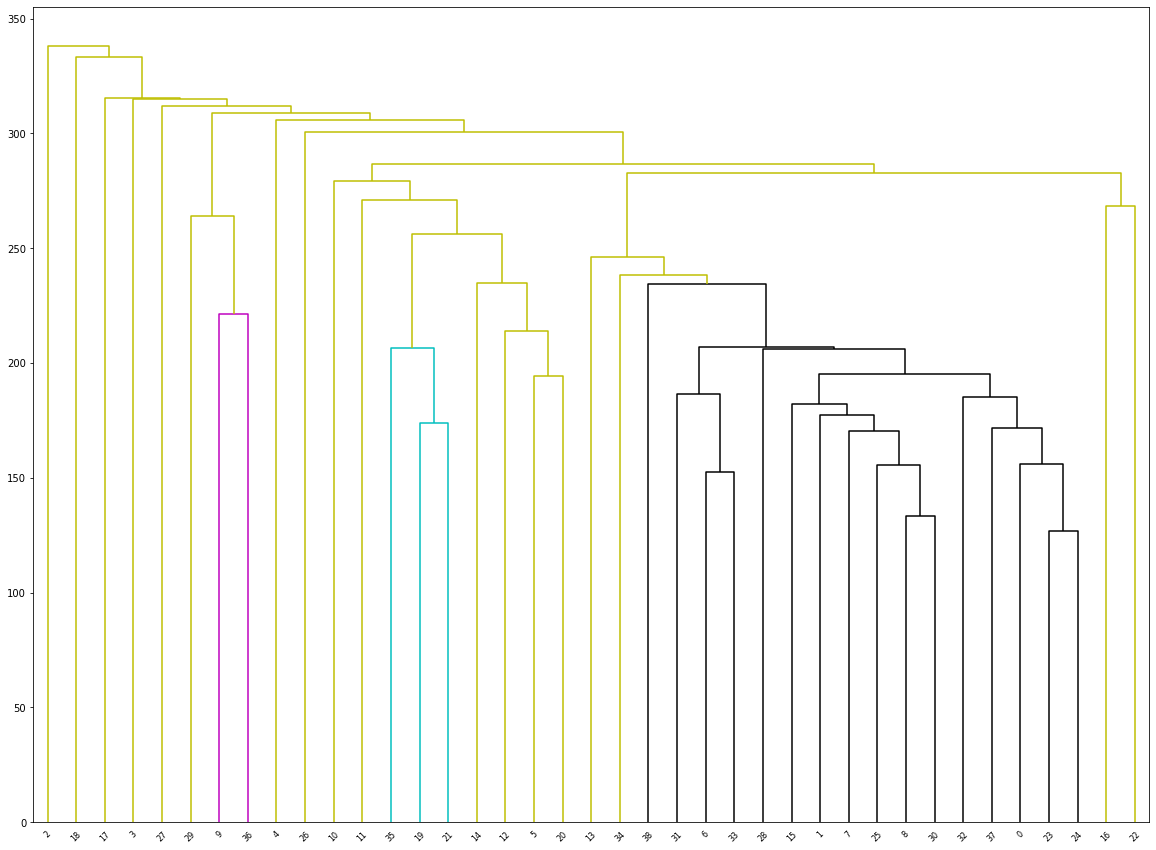

In [ ]:
linked = hierarchy.linkage(X, 'average', 'cityblock')

labelList = range(1, 52)

plt.figure(figsize=(20, 15))
hierarchy.dendrogram(linked, above_threshold_color='y')
plt.show()